# Time series user activation

We can have two types of activation:
- weak activation: is the first moment a user use the word "climate change" or "global warming"
- strong activation: is the first moment a user write in a subreddit of climate activism or climate action or climate discussion or climate skepticism. Strong activation is a stronger commitment than weak activation because the users decided to join a specific conversation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path += ["../src"]
import climact_utils as cu
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import numpy as np
from glob import glob
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
authors_activations_strong = pd.concat({subreddit_class: pd.read_csv(cu.data_path + f"first_activation_subreddit_class/{subreddit_class}.csv", index_col = 0).assign(date = lambda x: pd.to_datetime(x["date"]))
                        for subreddit_class in cu.subreddit_classes}).reset_index().drop("level_1", axis = 1).rename(columns = {"level_0": "subreddit_class"})

In [11]:
#### deleted first_activation/
# folder = sorted(glob(cu.data_path + "first_activations/we*"))
# authors_activations_weak = pd.concat([pd.read_pickle(file) for file in folder]).reset_index()

authors_activations_weak = pd.read_csv(cu.data_path + "author_weak_activation_date.csv").assign(date = lambda x: pd.to_datetime(x["date"]))

# folder = sorted(glob(cu.data_path + "first_activations/str*"))
# authors_activations_strong = pd.concat([pd.read_pickle(file) for file in folder])
authors_activations_strong = pd.concat({subreddit_class: pd.read_csv(cu.data_path + f"first_activation_subreddit_class/{subreddit_class}.csv", index_col = 0).assign(date = lambda x: pd.to_datetime(x["date"]))
                        for subreddit_class in ["activism"]}).reset_index().drop("level_1", axis = 1).rename(columns = {"level_0": "subreddit_class"})


In [12]:
print("Total number weak activations", len(authors_activations_weak))
print("Total number strong activations", len(authors_activations_strong))
print("Total different number strong activations", len(authors_activations_strong.author.unique()))

Total number weak activations 1477593
Total number strong activations 16528
Total different number strong activations 16528


In [16]:
print("2016-2022")
date0 = pd.to_datetime("2016-01-01")
date1 = pd.to_datetime("2023-01-01")
print("Total number weak activations", len(authors_activations_weak.query("@date0 < date < @date1")))
print("Total number strong activations", len(authors_activations_strong.query("@date0 < date < @date1")))
print("Total different number strong activations", len(authors_activations_strong.query("@date0 < date < @date1").author.unique()))

2016-2022
Total number weak activations 1056319
Total number strong activations 13648
Total different number strong activations 13648


In [14]:
authors_activations_weak = authors_activations_weak.query("@date0 < date < @date1")
authors_activations_strong = authors_activations_strong.query("@date0 < date < @date1")

In [15]:
print("Author in the intersection", len(list(set(authors_activations_weak.author)&set(authors_activations_strong.author))))

Author in the intersection 7073


In [7]:
intersection_df = authors_activations_weak.merge(authors_activations_strong, on = "author", suffixes = ["_weak", "_strong"])\
    .assign(diff_activations = lambda x: [u.days + u.seconds / (24 * 3600) for u in (x["date_strong"] - x["date_weak"])])\
    .assign(weak_then_strong = lambda x: x["date_strong"] > x["date_weak"], simultaneous_activation = lambda x: x["date_strong"] == x["date_weak"])

In [8]:
print("Total author weak activated before strong", len(intersection_df.query("weak_then_strong")))
print("Proportion author weak activated before strong", len(intersection_df.query("weak_then_strong")) / len(intersection_df))

Total author weak activated before strong 33190
Proportion author weak activated before strong 0.6275644298220735


In [10]:
weak_activation_count = authors_activations_weak.groupby(pd.Grouper(key = "date", freq = "w")).count()["author"].reset_index()
strong_activation_count = authors_activations_strong.groupby(pd.Grouper(key = "date", freq = "w")).count()["author"].reset_index()

In [11]:
activation_count = pd.concat([weak_activation_count.assign(activation = "weak"), strong_activation_count.assign(activation = "strong")]).reset_index().rename(columns = {"author": "count"})

### Total number activations

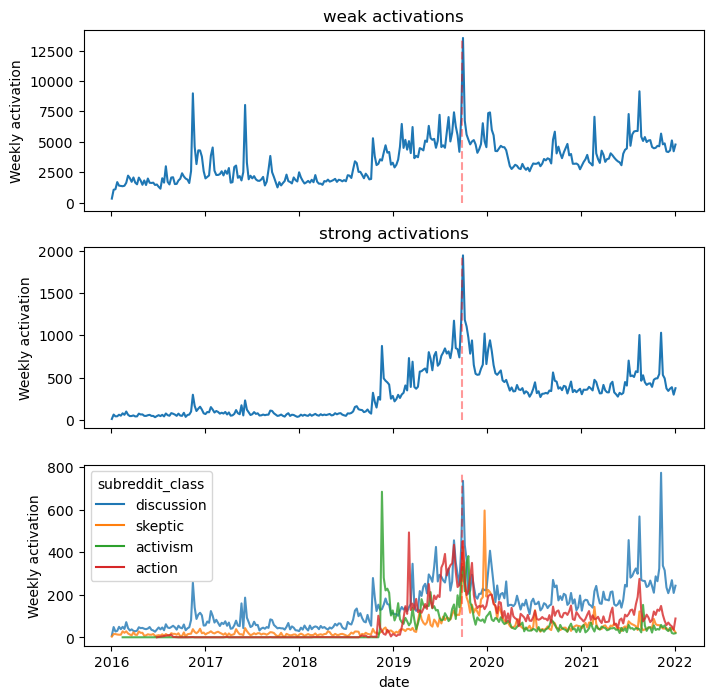

In [12]:
fig, axes = sbp(nrows = 3, figsize = (8,8), sharex = True)
for i,activation in enumerate(["weak", "strong"]):
    sns.lineplot(data = activation_count.query("activation == @activation"), x = "date", y = "count", ax = axes[i])
    axes[i].set_title(f"{activation} activations")
    axes[i].vlines(x = pd.to_datetime("2019-09-25"), ymin = 0, ymax = activation_count.query("activation == @activation").max()["count"], colors = "red", linestyle = "dashed", alpha = 0.4)
for i in range(3):
    axes[i].set_ylabel("Weekly activation")
    axes[i].set_xlabel("")
    
activation_count_classes = authors_activations_strong.groupby([pd.Grouper(key = "date", freq = "w"), "subreddit_class"]).count()["author"].reset_index().rename(columns = {"author": "count"})
sns.lineplot(data = activation_count_classes, alpha = 0.8,
             x = "date", y = "count", hue = "subreddit_class", ax = axes[2])
axes[2].vlines(x = pd.to_datetime("2019-09-25"), ymin = 0, ymax = activation_count_classes.max()["count"], colors = "red", linestyle = "dashed", alpha = 0.4)
fig.show()

<Axes: xlabel='date', ylabel='count'>

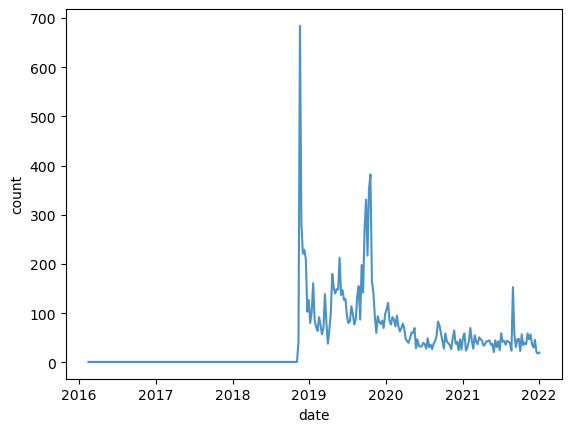

In [13]:
sns.lineplot(data = activation_count_classes.query("subreddit_class == 'activism'"), alpha = 0.8,
             x = "date", y = "count")


### Activations in the intersection

In [43]:
# initial_date = pd.to_datetime("20160101")
# intersection_df_filt = intersection_df.query("@date0 < date_weak < @initial_date")

In [62]:
activation_window = intersection_df.query("weak_then_strong")["diff_activations"]

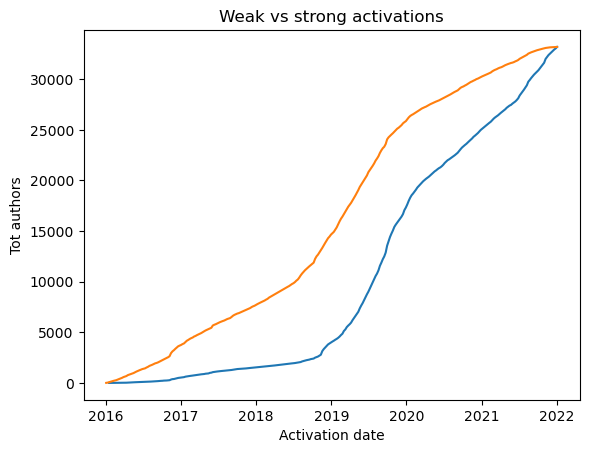

In [64]:
fig, axes = sbp()
axes.plot(intersection_df.query("weak_then_strong").sort_values("date_strong").groupby(pd.Grouper(key = "date_strong", freq = "w")).count()["author"].cumsum())
axes.plot(intersection_df.query("weak_then_strong").sort_values("date_weak").groupby(pd.Grouper(key = "date_weak", freq = "w")).count()["author"].cumsum())
axes.set_xlabel("Activation date")
axes.set_ylabel("Tot authors")
axes.set_title("Weak vs strong activations")
fig.show()

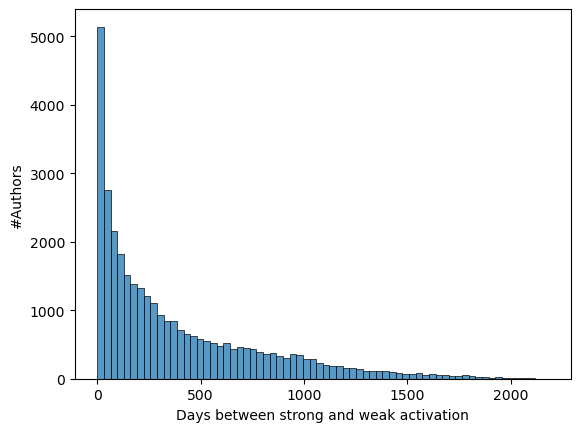

In [65]:
fig, axes = sbp()
sns.histplot(activation_window)
axes.set_xlabel("Days between strong and weak activation")
axes.set_ylabel("#Authors")
fig.show()

#### Authors climate activism

In [3]:
authors_activations_strong = pd.read_csv(cu.data_path + f"first_activation_subreddit_class/activism.csv", index_col = 0).assign(date = lambda x: pd.to_datetime(x["date"]))
authors_activations_weak = pd.read_csv(cu.data_path + "author_weak_activation_date.csv").assign(date = lambda x: pd.to_datetime(x["date"]))

In [4]:
print("N weak activations", len(authors_activations_weak))
print("N strong activations", len(authors_activations_strong))

N weak activations 1477593
N strong activations 16528


In [5]:
weak_and_strong_activations = authors_activations_strong.merge(authors_activations_weak[authors_activations_weak["author"].isin(authors_activations_strong["author"])], on = "author", suffixes = ["_strong", "_weak"])[["author", "subreddit", "date_strong", "date_weak"]]

In [6]:
print("N weak and strong activation", len(weak_and_strong_activations))

N weak and strong activation 9247


In [7]:
print("N weak before strong", len(weak_and_strong_activations.query("date_strong > date_weak")))


N weak before strong 6928


In [8]:
date0 = pd.to_datetime("2016-01-01")
date1 = pd.to_datetime("2022-05-01")

authors_in_interval = weak_and_strong_activations.query("(date_weak < date_strong)&(date_weak > @date0)&(date_strong < @date1)")
print("N weak before strong in interval", len(authors_in_interval))

N weak before strong in interval 5315


In [9]:
authors_in_two_years = authors_in_interval.assign(diff_activations = lambda x: [u.days + u.seconds / (24 * 3600) for u in (x["date_strong"] - x["date_weak"])]).query("diff_activations < (366 * 2)")

In [10]:
authors_in_two_years["subreddit"].value_counts().reset_index()

,subreddit,count
0,ExtinctionRebellion,1979
1,EarthStrike,1928
2,FridaysForFuture,178
3,SunriseMovement,127
4,sierraclub,5
5,ClimateRealityProject,4


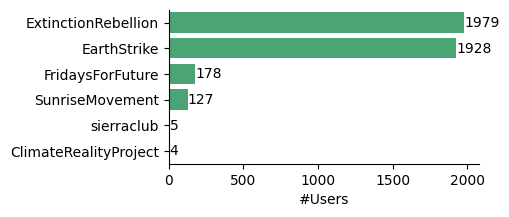

In [12]:
fig, axes = sbp(figsize = (4,2))

data = authors_in_two_years["subreddit"].value_counts().reset_index()
sns.barplot(data = data, x = "count", y = "subreddit", color = "mediumseagreen")
for index, d in data.iterrows():
    axes.annotate(text = d["count"], xy = (d["count"], index), color = "black", va = "center")
axes.set_ylabel("")
axes.set_xlabel("#Users")

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.savefig("../paper/hist_subreddit_activism.pdf", format = "pdf", bbox_inches = "tight")